### Introduction
[insert intro here]

### Setup
First we can load in the data as a Pandas dataframe.

In [183]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

We can then look at the dataframe we have made:

In [184]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


We can shorten the species of the penguins to just the first word, which will make it easier to catalogue them.

In [185]:
train["Species"] = train["Species"].str.split().str.get(0)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


### Figure Creation
Now that we've preprocessed the data, we can create a few plots to get an idea of what this data means.

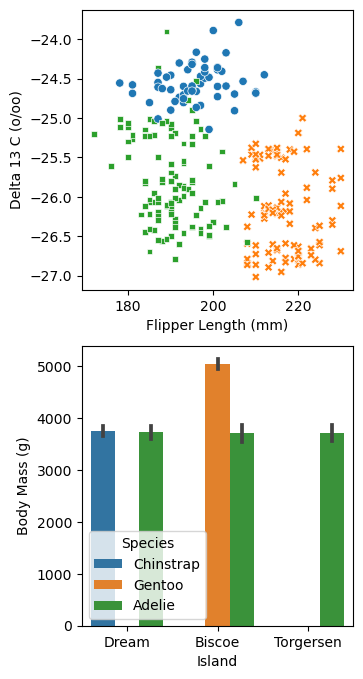

In [186]:
fig, ax = plt.subplots(2, 1, figsize = (3.5, 8))

p1 = sns.scatterplot(train, x = "Flipper Length (mm)", y = 'Delta 13 C (o/oo)', hue = "Species", style = "Species", ax = ax[0], legend=False)
p2 = sns.barplot(train, x = "Island", y = "Body Mass (g)", hue = 'Species')

### Deciding on attributes
We now need to pick the attributes that will yield the best prediction accuracy.

In [187]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

x_train, y_train = prepare_data(train)
x_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,51.1,16.5,225.0,5250.0,8.20660,-26.36863,True,False,False,True,False,True,False,True
271,35.9,16.6,190.0,3050.0,8.47781,-26.07821,False,False,True,True,True,False,True,False
272,39.5,17.8,188.0,3300.0,9.66523,-25.06020,False,True,False,True,False,True,True,False
273,36.7,19.3,193.0,3450.0,8.76651,-25.32426,False,False,True,True,False,True,True,False


In [188]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression

all_qual_cols = ["Clutch Completion", "Island", "Sex", "Stage"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]
scores = []
combo_array = []
for qual in all_qual_cols: 
  qual_cols = [col for col in x_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    combo_array.append(cols)
    LR = LogisticRegression()
    LR.fit(x_train[cols], y_train)

for combo in combo_array:
  LR = LogisticRegression()
  LR.fit(x_train[combo], y_train)  
  new_score = LR.score(x_train[combo], y_train)
  scores.append((combo, new_score))


/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ellisterling/anaconda3/envs/ml-0451/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [189]:
from operator import itemgetter
best_combo = max(scores, key = itemgetter(1))
print(best_combo)

(['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'], 0.99609375)


It looks like Island, Culmen Length, and Culmen Depth are our most helpful attributes.

In [190]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)
x_test, y_test = prepare_data(test)
LR.score(x_test[cols], y_test)

0.8235294117647058